# APPENDIX
# Problem 1 - Economic Dispatch

In [24]:
import numpy as np
import cvxpy as cp

import matplotlib.pyplot as plt

# Definition of data

In [6]:
generation_costs = np.array([15, 20, 15, 20, 30, 25.])
capacity = np.array([10, 5, 10, 10, 20, 30.])
ramp_up_rate = np.array([2, 5, 2, 5, 10, 5.])
ramp_down_rate = np.array([2, 5, 2, 5, 10, 5.])

In [7]:
rt = np.array([15.2, 16.4, 16.1, 10.9, 14.8, 7.6, 15.6, 5.5, 9.2, 5.7, 1.5, 12.4, 10.4, 4.8, 14.3, 0.5, 6.6, 5.7, 11.5, 11.9, 2.8, 7.3, 6.7, 9.7])
dt = np.array([21.3, 21.4, 17.8, 20.9, 15.5, 17.6, 20.2, 23.8, 27.7, 30.1, 35.4, 39.4, 43.2, 47.0, 49.3, 51.5, 52.6, 50.3, 47.0, 43.1, 38.8, 33.2, 28.6, 24.3])

# Question 1.1

In [8]:
# YOUR CODE HERE
# We recommend GLPK solver
Ng = 6  # number of traditional generators
T = 24  # planning horizon
# Define variables
gt = cp.Variable((Ng, T))  # production of each traditional generator 
                           # over the planning horizon
# Construct the problem
objective = cp.Minimize(cp.sum(generation_costs @ gt))
constraints = [dt == cp.sum(gt, axis=0) + rt,
               0 <= gt, gt <= np.tile(capacity, (T, 1)).T,
               gt[:, 1:] - gt[:, :-1] <= np.tile(ramp_up_rate, (T-1, 1)).T,
               gt[:, :-1] - gt[:, 1:] <= np.tile(ramp_down_rate, (T-1, 1)).T]
problem = cp.Problem(objective, constraints)

# Solve with GLPK.
problem.solve(solver=cp.GLPK)
print(f"optimal value with GLPK: {problem.value}", np.sum(gt.value, axis=1), sep='\n')
print("per generator", np.sum(gt.value))

GLPK Simplex Optimizer, v4.65
588 rows, 144 columns, 984 non-zeros
optimal value with GLPK: 10158.5
[177.6  64.2 160.9 127.4  15.8  31. ]
per generator 576.9
      0: obj =   0.000000000e+00 inf =   5.769e+02 (24)
    138: obj =   1.041700000e+04 inf =   0.000e+00 (0)
*   195: obj =   1.015850000e+04 inf =   0.000e+00 (0) 1
OPTIMAL LP SOLUTION FOUND


In [9]:
opti_git_values = np.round_(gt.value, 1)

for i in range(0, len(opti_git_values)):
    print('Optimal g{}^t values:\n'.format(i+1), opti_git_values[i])

Optimal g1^t values:
 [ 5.7  3.7  1.7  2.7  0.7  2.7  2.6  4.6  6.6  8.6 10.  10.  10.  10.
 10.  10.  10.  10.  10.  10.  10.  10.  10.   8. ]
Optimal g2^t values:
 [0.  0.  0.  5.  0.  5.  0.  5.  5.  2.8 3.9 0.  2.8 5.  4.  5.  5.  5.
 4.5 1.2 5.  0.  0.  0. ]
Optimal g3^t values:
 [ 0.4  1.3  0.   2.   0.   2.   2.   4.   6.   8.  10.  10.  10.  10.
 10.  10.  10.  10.  10.  10.  10.  10.   8.6  6.6]
Optimal g4^t values:
 [ 0.   0.   0.   0.3  0.   0.3  0.   4.7  0.9  5.  10.   7.  10.  10.
 10.  10.  10.  10.  10.  10.  10.   5.9  3.3  0. ]
Optimal g5^t values:
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   2.2
  0.  10.   0.   3.6  0.   0.   0.   0.   0.   0. ]
Optimal g6^t values:
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  5.  1.  6. 11.  6.
  1.  0.  1.  0.  0.  0.]


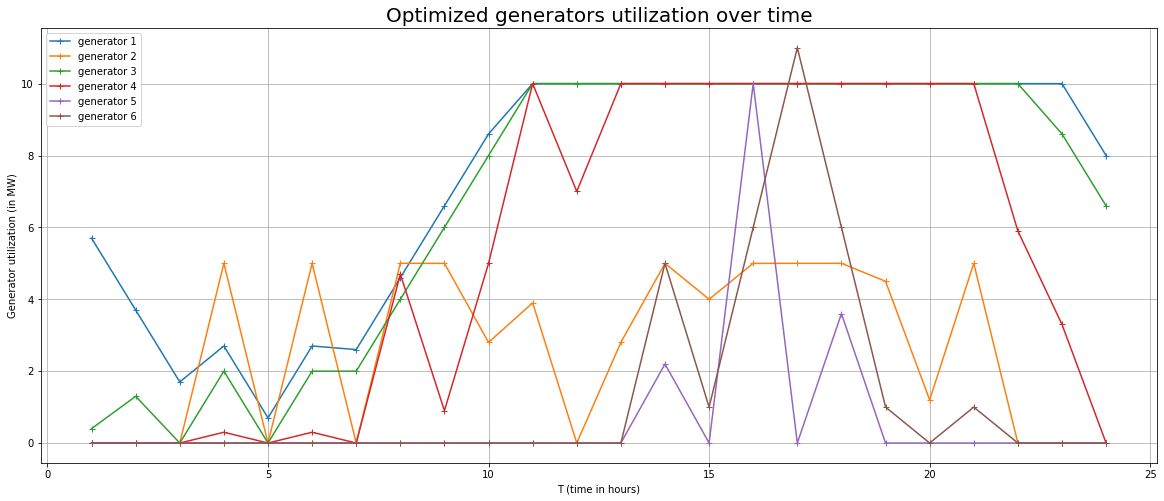

In [11]:
plt.figure(figsize=(20,8))

x = range(1, 25)

for i in range(0, len(gt.value)):
    plt.plot(x, gt.value[i], label='generator '+str(i+1), marker='+')

plt.ylabel('Generator utilization (in MW)')
plt.xlabel('T (time in hours)')
plt.title('Optimized generators utilization over time', fontsize=20)
plt.legend()
plt.grid()

plt.savefig('ex1.1.a.png')
plt.show()

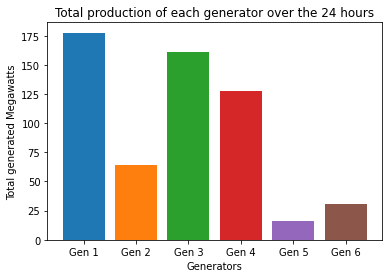

In [12]:
data = np.sum(gt.value, axis=1)

labels = ['Gen 1', 'Gen 2', 'Gen 3', 'Gen 4', 'Gen 5', 'Gen 6']
default_numpy_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize=(6,4))

plt.xticks(range(len(data)), labels)
plt.xlabel('Generators')
plt.ylabel('Total generated Megawatts')
plt.title('Total production of each generator over the 24 hours')
plt.bar(range(len(data)), data, color = default_numpy_colors[0:6])

plt.savefig('ex1.1.b.png')
plt.show()

# Question 1.2

In [13]:
nu_d = 0.92
nu_c = 0.95
S_bar = 20

In [14]:
# YOUR CODE HERE
# We recommend GLPK solver
Ng = 6  # number of traditional generators
T = 24  # planning horizon
# Define variables
gt = cp.Variable((Ng, T))  # production of each traditional generator
S = cp.Variable(T+1)  # battery state of charge
bdt = cp.Variable(T)  # battery discharge over planning horizon
bct = cp.Variable(T)  # battery charge over the planning horizon
# Construct the problem
objective = cp.Minimize(cp.sum(generation_costs @ gt))
constraints = [dt == cp.sum(gt, axis=0) + rt + nu_d*bdt - bct,
               0 <= gt, gt <= np.tile(capacity, (T, 1)).T,
               gt[:, 1:] - gt[:, :-1] <= np.tile(ramp_up_rate, (T-1, 1)).T,
               gt[:, :-1] - gt[:, 1:] <= np.tile(ramp_down_rate, (T-1, 1)).T,
               # 0 <= bdt, 0 <= bct,
               # 0 <= bdt, bdt <= S[:-1], 0 <= bct, bct <= S_bar - S[1:],
               # 0 <= bdt, bdt <= S[:-1] + nu_c*bct, 0 <= bct, bct <= (S_bar - S[1:]) + bdt,
               0 <= S, S <= S_bar,
               S[0] == 0, S[1:] == S[:-1] - bdt + nu_c*bct, S[-1] == 0,
               0 <= bdt, bdt <= S[:-1] + nu_c*bct, 
               0 <= bct, bct <= (S_bar - S[:-1]) + bdt, ]
problem = cp.Problem(objective, constraints)

# Solve with GLPK.
problem.solve(solver=cp.GLPK, verbose=0)
print(f"optimal value with GLPK: {problem.value}", np.sum(gt.value, axis=1), '∆charge', nu_c*bct.value - bdt.value, 'charge', S.value, sep='\n')


optimal value with GLPK: 9777.750582125813GLPK Simplex Optimizer, v4.65
760 rows, 217 columns, 1372 non-zeros

[2.06200000e+02 4.51441666e+01 1.82937069e+02 1.19515561e+02
 1.22124533e-15 2.59000001e+01]
∆charge
[ 0.00000000e+00  0.00000000e+00  4.08500000e+00  8.88178420e-16
  5.51982759e+00  4.84827586e-01  9.41482759e+00  1.99827586e-01
  2.80905172e-01  1.40452586e-02  7.02262931e-04  3.51131465e-05
  1.75565733e-06 -2.49999991e+00  0.00000000e+00 -1.19565217e+01
 -1.08695652e+00 -4.45652174e+00  0.00000000e+00  1.08695652e+00
 -1.08695652e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]      0: obj =   0.000000000e+00 inf =   5.769e+02 (24)
    156: obj =   1.036290108e+04 inf =   0.000e+00 (0)
*   301: obj =   9.777750582e+03 inf =   1.776e-15 (0) 1
OPTIMAL LP SOLUTION FOUND

charge
[ 0.          0.          0.          4.085       4.085       9.60482759
 10.08965517 19.50448276 19.70431034 19.98521552 19.99926078 19.99996304
 19.99999815 19.99999991 17.5        17.5         

In [15]:
opti_git_values = np.round_(gt.value, 1)

for i in range(0, len(opti_git_values)):
    print('Optimal g{}^t values:\n'.format(i+1), opti_git_values[i])

Optimal g1^t values:
 [ 6.1  4.1  4.   6.   4.   6.   8.  10.  10.  10.  10.  10.  10.  10.
 10.  10.  10.  10.  10.  10.  10.  10.  10.   8. ]
Optimal g2^t values:
 [ 0.   0.   0.   0.   0.  -0.   0.   0.  -0.  -0.   5.   0.   2.8  5.
  5.   5.   5.   5.   5.   2.3  5.   0.   0.   0. ]
Optimal g3^t values:
 [ 0.   0.9  2.   4.   2.5  4.5  6.5  8.5  8.8 10.  10.  10.  10.  10.
 10.  10.  10.  10.  10.  10.  10.  10.   8.6  6.6]
Optimal g4^t values:
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   4.4  8.9  7.  10.  10.
 10.  10.  10.  10.  10.  10.  10.   5.9  3.3  0. ]
Optimal g5^t values:
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0. -0.
  0.  0.  0.  0.  0.  0.]
Optimal g6^t values:
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   4.9
  0.   5.  10.   5.5  0.5  0.   0.   0.   0.   0. ]


In [16]:
print('Energy in battery (S_t):\n', np.round_(S.value, 1))

Energy in battery (S_t):
 [ 0.   0.   0.   4.1  4.1  9.6 10.1 19.5 19.7 20.  20.  20.  20.  20.
 17.5 17.5  5.5  4.5  0.   0.   1.1  0.   0.   0.   0. ]


In [17]:
print('Energy used charging battery (bct):\n', np.round_(bct.value, 1))

Energy used charging battery (bct):
 [0.  0.  4.3 0.  5.8 0.5 9.9 0.2 0.3 0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  1.1 0.  0.  0.  0. ]


In [18]:
print('Energy taken from battery (bdt):\n', np.round_(bdt.value, 1))

Energy taken from battery (bdt):
 [ 0.   0.   0.  -0.   0.   0.   0.  -0.   0.   0.   0.   0.   0.   2.5
  0.  12.   1.1  4.5  0.   0.   1.1  0.   0.   0. ]


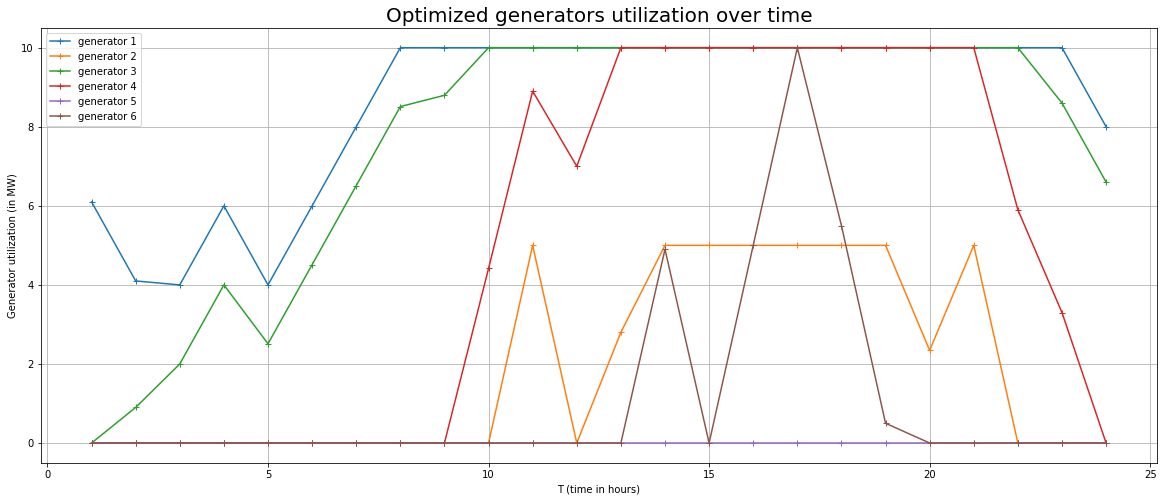

In [21]:
plt.figure(figsize=(20,8))

x = range(1, 25)

for i in range(0, len(gt.value)):
    plt.plot(x, gt.value[i], label='generator '+str(i+1), marker='+')

plt.ylabel('Generator utilization (in MW)')
plt.xlabel('T (time in hours)')
plt.title('Optimized generators utilization over time', fontsize=20)
plt.legend()
plt.grid()

plt.savefig('ex1.3.a.png')
plt.show()

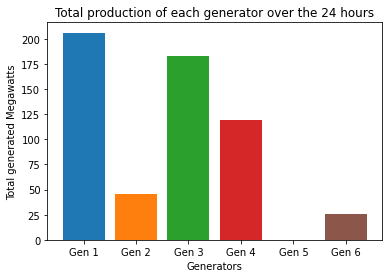

In [20]:
data = np.sum(gt.value, axis=1)

labels = ['Gen 1', 'Gen 2', 'Gen 3', 'Gen 4', 'Gen 5', 'Gen 6']
default_numpy_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize=(6,4))

plt.xticks(range(len(data)), labels)
plt.xlabel('Generators')
plt.ylabel('Total generated Megawatts')
plt.title('Total production of each generator over the 24 hours')
plt.bar(range(len(data)), data, color = default_numpy_colors[0:6])

plt.savefig('ex1.3.b.png')
plt.show()

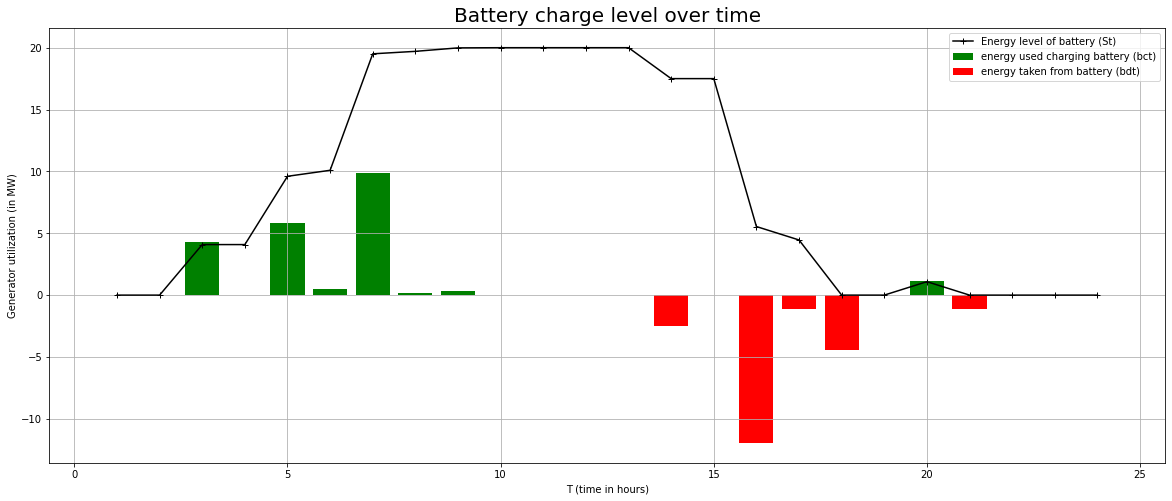

In [22]:
plt.figure(figsize=(20,8))

x = range(1, 25)

plt.bar(x, bct.value, color='green', label='energy used charging battery (bct)')
plt.bar(x, -1*bdt.value, color='red', label='energy taken from battery (bdt)')
plt.plot(x, S.value[1:], label='Energy level of battery (St)', marker='+', color='black')

plt.ylabel('Generator utilization (in MW)')
plt.xlabel('T (time in hours)')
plt.title('Battery charge level over time', fontsize=20)
plt.legend()
plt.grid()

plt.savefig('ex1.3.c.png')
plt.show()